# Tutorial on Learning under Complexity

In this tutorial, you will be introduced to a simple model that replicates the main finding from the paper by Dan Levinthal, published in 1997 in Management Science. 

This tutorial provides a barebones description of the model. If you want to explore a more flexible version or explore how different agents or bandit distributions would affect Dan's results please employ Maciej Workiewicz's code (https://www.maciejworkiewicz.com/coding). There you will find code on how to replicate also other seminal papers on NK landscapes.

**Reference:** Levinthal, D. A. (1997). Adaptation on rugged landscapes. Management science, 43(7), 934-950.

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Basic building blocks
Below I introduce the code for searching in NK landscape, equivalent to the one from Levithnal (1997)
For this I create a agent class. The agent is very simple, it just knows the percentage of time it can make a long jump. 
Levinthal includes other aspects like myopia but this is not in the code at the moment. 

## 1. Landscape
An NK landscape outputs a payoff value for an input policy. It is is equivalent to getting an elevation value after providing the longitude and latitude in a map. That is the reason why it is called a landscape. However, the inputs of an NK landscape are binary thus the analogy does not go to far.  
Overall, the landscape receives a policy and outputs a payoff for this policy. The policy consists in N binary values stored as a string of 0s and 1s (e.g. '101'). The payoff depends on the value of K of the NK model. 

K represents the amount of interdependencies that are linked to the performance of each of the N variables. In an environment where K=0, then the performance of the policy value depends only on its own value, if 0 then x0 if 1 then x1. It does not depend on the other N-1 elements. If K > 0 then the payoff for this policy element depends on the value of some of the N-1 elements of the policy. If K = N-1 then the payoff of this policy element depends on the value of all the other N-1 policy element. The higher the K the higher the complexity of the interrelationships when calculating the performance of each policy.    
### 1.1 Create dependencies
The first step to create a landscape is creating the dependency matrix. Here one takes N and K and fills an N by N matrix with 1s in the diagonal and N*K 1s in the off diagonal. On each row there are on average K 1s in the off-diagonal, and always a 1 in the diagonal. 

### 1.2 Fitness contribution
Having the interdependency matrix. We can create the fitness contributions. These basically determine the payoff each policy element receives. There are in total N different sets of fitness contribution functions. Each of the N sets has 2^k+1 different values for all the combinations of the policies that matter for the policy element at hand.  
The fitness contribution is created by filling a list with N dictionaries. Each dictionary has as key value a combination of policies that affect the payoff of the policy element (e.g. '010') and as value a draw from an uniform distribution.  

### 1.3 Payoff
The fitness contributions are used to calculate the total payoff of each policy. For this we need a way of taking a policy and determining the interactions that each policy element makes in order to estimate its payoff contribution.   
This requires several steps. Firts we need to obtain the keys for the fitness contributions. that is we take a policy (e.g. '101']) and determine for every policy element the key value for the fitness contribution.  
  
Let's imagine that the interdependency matrix is:  
  
|1 0 0|  
|0 1 1|  
|1 1 1|  

From Levinthal (1997), we would see that the first key value is '1', the second '01', and the third '101'. In the code below, the functions transfor_matrix and transform_row are in charge of making the translation from a policy to the key values. 
  
After having the key values, we can calculate the performance of each policy element by addressing the fitness contribution list of each element, and then averaging them. The total payoff for one fitness contribution is this average. 

### 1.4 Calculate landscape
After having a function that calculate the performance of one policy we can calculate the full landscape by running a for-loop over each policy value. 

### 1.6 Landscape initiation
To initiate a landscape one just needs to give the N and K value. The landscape is created with the use of the reset function.

### 1.5 Reset
The reset function creates a landscape by first building the dependency matrix, then the fitness contributions, and lastly the full-landscape from the prior two. For doing this it just requires the N and K values given at the initiation of the class. 

### 1.6 Summary
The summary function outputs the maximum, minimum, and number of peaks in the landscape. 

### 1.7 Miscellaneous functions  
#### 1.7.1 Int2Pol
This function translates an integer value to a string of 0s and 1s. This string is made so that it has length N.
For example 5 is translated in to '101' in the case of N=3 or '0101' in case N = 4

#### 1.7.2 Transform matrix
Handles the transformation of a policy into the key values for estimating its payoff. For this it uses transform_row for every policy element. 

#### 1.7.3 Transform row
Uses the policy and interacts it with a row of the dependency matrix. The length of the output depends on the number of 1s in the row of the interdependency matrix. For example if the policy is '101' and the row is [0,1,1] then the output is '01'. If the row was [1,0,0] then the output would be '1'.   
This transformation gives always the same value and thus can be used with the fitness contribution to estimate the payoff for each policy element.

In [1]:
import numpy as np
import pandas as pd # used only for storage
import matplotlib.pyplot as plt

def int2pol(pol_int, n):
    pol = bin(pol_int)
    pol = pol[2:] # removes the '0b'
    if len(pol) < n: pol = '0'*(n-len(pol)) + pol
    return(pol)

def transform_matrix(policy, dep_mat):
    int_mat = [transform_row(policy, dep_mat[i]) for i in range(len(dep_mat))]
    return(int_mat)

def transform_row(policy, dep_row):
    interact_row = [policy[i] for i in range(len(policy)) if dep_row[i] == 1]
    trans_pol = ''
    for pol_i in interact_row: trans_pol += pol_i
    return(trans_pol)

class landscape:
    def __init__(self, n, k, land_style):
        self.n = n
        self.k = k
        self.land_style = land_style
        self.reset()
    def calc_landscape(self):
        land = {}
        for i in range(2**self.n):
            pol = int2pol(i,self.n)
            land[pol] = self.payoff(pol)
        self.lands = land
    def create_dependencies(self):
        self.dep_mat = np.zeros((self.n,self.n)).astype(int)
        if self.land_style == "Rand_mat": 
            inter = np.random.choice([1]*self.k*self.n+[0]*(self.n-self.k-1)*self.n, replace = False, size = self.n*(self.n-1))
        for i in range(self.n):
            if self.land_style == "Rand_row": 
                inter = np.random.choice([1]*self.k+[0]*(self.n-self.k-1), replace = False, size = (self.n-1))
            elif self.land_style == "Levinthal": inter = ([1]*self.k+[0]*(self.n-self.k-1))
            range_row = list(range(self.n)[i:])+list(range(self.n)[:i])
            for j in range_row:
                if i != j: 
                    self.dep_mat[i][j] = inter[0]
                    inter = inter[1:]
                else: self.dep_mat[i][i] = 1
    def fitness_contribution(self):
        self.fit_con = []
        for i in range(self.n): 
            epi_row = {int2pol(j,sum(self.dep_mat[i])): np.random.random() 
                       for j in range(2**sum(self.dep_mat[i]))}
            self.fit_con.append(epi_row)
    def payoff(self, policy):
        keys = transform_matrix(policy, self.dep_mat)
        pay = np.sum([self.fit_con[i][keys[i]]/len(policy) for i in range(len(policy))])
        return(pay)
    def reset(self):
        self.create_dependencies()
        self.fitness_contribution()
        self.calc_landscape()
    def reset_one(which_pol):
        self.fit_con[which_pol] = {int2pol(i,sum(self.dep_mat[which_pol])): np.random.random() 
                                   for i in range(2**sum(self.dep_mat[which_pol]))}
        self.calc_landscape()        
    def summary(self):
        max_global = max(self.lands.values())
        min_global = min(self.lands.values())
        num_peaks = 0
        for current_row in self.lands.keys():
            randomized_neighbors = find_neighbors(current_row)
            counter = 0
            for neighbor in randomized_neighbors:
                if self.lands[current_row] < self.lands[neighbor]: counter += 1
            if counter == 0: num_peaks += 1
        return([max_global, min_global, num_peaks])

## 2. Agents

### 2.1 Initiation
The agent is created by giving the probability of making a long jump instead of searching its neighbors. Everything else is done through its search function.

### 2.2 Search
The search function receives a landscape and the number of periods it has to search the landscape. On every periods, it has the opportunity of making a long jump and staying in the position if it has a higher payoff or searching the neighboring positions.  
The agent decides to move to a new position only if the payoff is higher than the current payoff. Any change of position is logged into a short log, and even if there is no change, the current position is logged into a longer log. If the global maximum is found, then the agent stores a 1 and the period when the global maximum was reached.  

### 2.3 Find neighbors
The main form of movement for the agent is local search. This implies moving to each neighboring position and staying in the first that gives a higher payoff. In order to do this the agent needs to find its neighbors. This can be done in several ways, here what we do is to morph the current position by flipping one policy element and storing it as a neighbor. We do this for every policy element to make a list of neighbors. We randomize the order of neighbors to avoid bias and use this for local search. 



In [2]:
def find_neighbors(policy):
    policy = (policy) #policy changed 
    neighbors = []
    random_order = np.random.choice(range(len(policy)), replace = False, size = len(policy))
    for i in random_order:
        neighbor = list(policy)
        if policy[i] == '1': neighbor[i] = '0'
        else: neighbor[i] = '1'
        neighbors.append(''.join(neighbor))
    return(neighbors)

class agent:
    def __init__(self, long_jump, start_pos, noise):
        self.long_jump = long_jump
        self.start_pos = start_pos
        self.noise = noise
    def search(self, lands, num_periods):
        # Where to start?
        if self.start_pos == "Minimum": current_row = min(lands, key=lands.get)
        elif self.start_pos == "Random": current_row = np.random.choice(list(lands.keys()))
        # Initialize logs and find maximum
        global_max = max(lands, key=lands.get)
        log_short = [{"policy":current_row, "payoff":lands[current_row]}]
        log_long = [{"policy":current_row, "payoff":lands[current_row]}]
        # Start search
        for j in range(num_periods):
            # Local search or Jump?
            walk_or_jump = np.random.choice(["Walk", "Jump"], p = [1-long_jump, long_jump])
            if walk_or_jump == "Walk":
                randomized_neighbors = find_neighbors(current_row)
                for proposed_row in randomized_neighbors:
                    ruido = (np.random.random()-0.5)*self.noise # just 1 difference
                    if lands[proposed_row] + ruido > lands[current_row]: break
            elif walk_or_jump == "Jump": 
                proposed_row = np.random.choice(list(lands.keys())) #could be improved not past or current
                ruido = (np.random.random()-0.5)*self.noise*np.sum([1*(proposed_row[i] != current_row[i]) 
                                                                    for i in range(len(proposed_row))])
            # Store new position if higher
            if lands[proposed_row] + ruido > lands[current_row]:
                current_row = proposed_row
                log_short.append({"policy":current_row, "payoff": lands[current_row]}) #stores changes
            log_long.append({"policy":current_row, "payoff": lands[current_row]}) #stores every period
            # Check if search is finished
            if current_row == global_max:
                if j < num_periods-1: # somehow the & did not work
                    for k in range(num_periods-j-1): 
                        log_long.append({"policy":current_row, "payoff": lands[current_row]}) # fill after maximum is found
                    break # stop the main for-loop after global maximum is found
        # Store data
        log_short.append({"policy":global_max, "payoff": lands[global_max]}) # add global max for comparison later on
        log_long.append({"policy":global_max, "payoff": lands[global_max]}) # add global max for comparison later on
        reached_max = 1*(current_row == global_max)
        return([reached_max, len(log_short)-1, j, pd.DataFrame(log_short), pd.DataFrame(log_long)])

## 3. Run Simulation
Having the agent and the landscape it is turn to perform the simulation. For this we use a function. This function takes the nubmer of repetitions, the number periods to simulate and the Agent and Landscape. The ismulation has two loops. One has the multiple agents searching in the same landscape and the other changes the landscape. At the end it outputs, the number of times the agents found the global maximum, the number of movements the agent did, the average periods when the maximum was reached, an array with the average payoffs received on every period, and an array of the variety of organizational forms at every period. 

In [3]:
def run_simulation(num_lands, num_reps, num_periods, Alice, Environment):
    all_reached_max = []
    all_num_steps = []
    all_num_trials = []
    all_payoffs = np.zeros(num_periods+2)
    all_choices = np.zeros(num_periods+2)
    for i in range(num_lands):
        int_reached_max = 0
        int_num_steps = 0
        int_num_trials = 0
        int_policy = []
        Environment.reset()
        for j in range(num_reps):
            reached_max, n_step, n_trial, o_short, o_long = Alice.search(lands = Environment.lands, num_periods = num_periods)
            int_reached_max += reached_max
            int_num_steps += n_step
            int_num_trials += n_trial
            all_payoffs = np.add(all_payoffs, o_long.payoff)
            int_policy.append(o_long.policy) 
        all_reached_max.append(int_reached_max)
        all_num_steps.append(int_num_steps)
        all_num_trials.append(int_num_trials)
        for m in range(num_periods+2): all_choices[m] += len(set([choice_list[m] for choice_list in int_policy]))
    return([all_reached_max, all_num_steps, all_num_trials, all_payoffs, all_choices])

# Levinthal (1997)
Below we run the simulation once and show the steps followed by one agent while searching the landscape. 
  
## 1. Initialize values

In [4]:
# Simulation
num_periods = 50
num_reps = 100
num_lands = 100
# Agent
long_jump = 0.1
noise = 0.0 # no noise 0.0, low noise 0.01, high noise 0.025
start_pos = "Random" # "Minimum", "Random"
# Landscape
n = 10
k = 1
land_style = "Levinthal" # "Levinthal", "Rand_mat", "Rand_row"

## 2. Initialize agent and landscape

In [5]:
Environment = landscape(n,k, land_style)    
Alice = agent(long_jump = long_jump, start_pos = start_pos, noise = noise)

## 3. Run simple search
Below we show one search of the environment and the short output of the search

In [6]:
reached_max, n_step, n_trial, output_short, output_long = Alice.search(Environment.lands, num_periods)
output_short

,payoff,policy
0,0.671409,0000110111
1,0.674998,0000110011
2,0.702542,1000110011
3,0.725599,1100110011
4,0.745410,1100110101


## 4. Run simulation
Additionally we run a simulation 1000 times to show the average form in which the agents explore the landscape. We print the percentage of times it reaches the global maximum, the number of movements done before the total number of periods were reached, the number of periods needed to find the maximum, and the time required to make the simulation. On average 50% of the agents reached the global maximum and they reached it around period 36. 

In [7]:
import time
start_time = time.time()
all_reached_max, all_num_steps, all_num_trials, all_payoffs, all_choices = run_simulation(num_lands, num_reps, num_periods, Alice, Environment)
print("% of time global max is reached: " + str(100*sum(all_reached_max)/(num_reps*num_lands)))
print("# of steps from start: " + str(sum(all_num_steps)/(num_reps*num_lands)))
print("# of periods to find global max: " + str(sum(all_num_trials)/(num_reps*num_lands)))
print("Computation time: "+ str(round(time.time()-start_time,2)))

% of time global max is reached: 44.26
# of steps from start: 5.8948
# of periods to find global max: 29.6842
Computation time: 103.63


### 4.1 Number of organizational forms
We can now plot the number of different solutions the agents go to on every period.

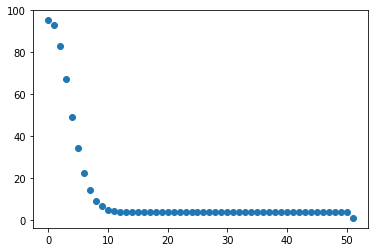

In [8]:
plt.scatter(range(num_periods+2), 100*all_choices[:num_periods+2]/(num_lands*num_reps))

### 4.2 Performance over time
We also plot the growth in payoff as the agents search the landscape. The last value is the average of the global maxima. Clearly, the search process is still distante to reaching the highest peak on every search ocassion. 

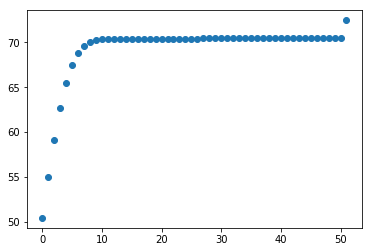

In [9]:
plt.scatter(range(num_periods+2), 100*(all_payoffs[:num_periods+2])/(num_lands*num_reps))

## 5. Descriptives of landscape

Finally we create 1000 landscapes and see their characteristics. Although making 1000 landscapes takes around 3 seconds, estimating their characteristics takes one order of magnitude longer. This is not a crucial step so I have not optimized it, yet.

Range of payoffs: [0.72, 0.5, 0.29]
Range # of peaks: [1, 3.64, 10]
Computation time: 19.99


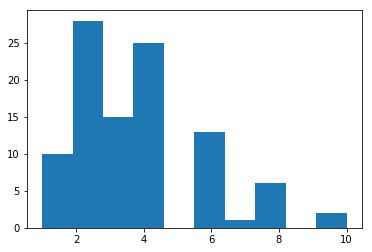

In [10]:
Environment = landscape(n,k, land_style)    
start_time = time.time()
all_max = []
all_min = []
all_num_peaks = []
for i in range(num_reps): 
    Environment.reset()
    max_val, min_val, peaks = Environment.summary()
    all_max.append(max_val)
    all_min.append(min_val)
    all_num_peaks.append(peaks)
print("Range of payoffs: " + str([round(np.mean(all_max),2), 0.5, round(np.mean(all_min),2)]))
print("Range # of peaks: " + str([min(all_num_peaks), round(np.mean(all_num_peaks),2), max(all_num_peaks)]))
plt.hist(all_num_peaks, bins=10)
print("Computation time: "+ str(round(time.time()-start_time,2)))

Levinthal (1997) includes more analyzes. These are yet to be implemented here. In the future, I will add the myopic jumping as this is important for the paper. 

**Note:** The code below produced the table of contents.

In [11]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>